In [1]:
import re
import nltk
import random
import numpy as np
from ollama import generate
from datasets import load_dataset
from collections import defaultdict
from ncastle.algorithms import RL
from ncastle.common import GraphDAG
from BCEmbedding import EmbeddingModel
from sklearn.metrics import accuracy_score
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('punkt_tab')

# init embedding model
model = EmbeddingModel(model_name_or_path="maidalun1020/bce-embedding-base_v1")
# 初始化新的嵌入模型
model_name = "maidalun1020/bce-embedding-base_v1"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'batch_size': 64, 'normalize_embeddings': True, 'show_progress_bar': False}
embed_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# 加载 WIQA 数据集（使用信任远程代码）
dataset = load_dataset("allenai/wiqa", trust_remote_code=True)
train_data = dataset["train"]  

def extract_answer(response: str) -> str:
    # 去除所有 <think>...</think> 部分
    cleaned = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL)
    return cleaned.strip()

def ask_ollama(prompt,model_name):    
    response = generate(
    model=model_name, 
    prompt=prompt
    )
    return response['response']

# 非递归：获取所有因果链（深度优先，避免重复节点）
def get_all_causal_paths_iterative(start_idx, causes_map):
    all_paths = []
    stack = [(start_idx, [start_idx])]

    while stack:
        current_idx, path = stack.pop()

        if current_idx not in causes_map or not causes_map[current_idx]:
            all_paths.append(path)
            continue

        extended = False
        for cause_idx in causes_map[current_idx]:
            if cause_idx not in path:  # 防止环
                stack.append((cause_idx, path + [cause_idx]))
                extended = True

        if not extended:
            all_paths.append(path)

    return all_paths

# 构造 prompt
def g_prompt(question, data, search_results, causal_relations):
    causes_map = defaultdict(list)
    for cause, effect, _ in causal_relations:
        causes_map[effect].append(cause)

    prompt_string = f"Question: {question}\n Context: \n"

    causal_result=[]
    seen_paths = set()
    global_path_idx = 1

    for i, sentence_idx in enumerate(search_results):
        causal_result.append(data[sentence_idx])

        # 查找从当前句子出发的所有因果路径
        all_paths = get_all_causal_paths_iterative(sentence_idx, causes_map)

        if all_paths:
            for path in all_paths:
                # 统一路径方向：因果链从因到果（即从头到当前句子）
                path_reversed = list(reversed(path))
                path_tuple = tuple(path_reversed)

                # 防止重复路径展示
                if path_tuple in seen_paths:
                    continue
                seen_paths.add(path_tuple)

                for step_idx, idx in enumerate(path_reversed):
                    causal_result.append(data[idx])
                global_path_idx += 1
    prompt_string += ';\n'.join(list(set(causal_result)))
    prompt_string += """\nChoose the most likely effect among the options:

- more
- less
- no effect

Respond ONLY with one of the three choices. Do NOT output any explanations."""

    return prompt_string

# 包装生成答案
def generate_answer(prompt,model_name):
    return extract_answer(ask_ollama(prompt,model_name))

def rl_generate_answer(question, context, model_name, encoder_type='TransformerEncoder'):
    prompt=f'''Please summarize each key information point of the following sentences point by point,
               using numbered format like 1. , 2. , and so on.  Do not use any titles, bold text, or formatting—only plain numbered points.
               Each point must preserve the original meaning exactly, with no added keywords, explanations, or paraphrasing.
               If the sentence implies a cause-effect relationship, clearly express the result (e.g., “produces more oil” instead of just “affects oil”).
               Strictly follow the original sentence structure while using simple declarative points.
               {question}'''
    text = generate_answer(prompt, model_name=model_name)
    points = re.findall(r"\d+\.\s*(.*)", text)
    
    chunks=points+context
    sentence_vectors = model.encode(chunks)
    sentence_vectors = np.array(sentence_vectors, dtype=np.float64)
    sentence_vectors = sentence_vectors.T

    rl = RL(nb_epoch=2500,batch_size=8,device_type='gpu',encoder_type=encoder_type)
    rl.learn(sentence_vectors)
    
    GraphDAG(rl.causal_matrix)
    
    # 输出所有因果关系
    causal_matrix = rl.causal_matrix
    n = causal_matrix.shape[0]
    causal_relations = []
    
    for i in range(n):
        for j in range(n):
            if causal_matrix[i, j] != 0:
                causal_relations.append((i, j, causal_matrix[i, j]))
    
    prompt = g_prompt(question, chunks, list(range(len(points))), causal_relations)
    
    return generate_answer(prompt,model_name)

# 更新后的评估函数，适配包含步骤字段的WIQA样本格式
def evaluate_model(model_name, rl=False ,max_samples=None, encoder_type='TransformerEncoder'):
    y_true = []
    y_pred = []
    
    if max_samples:
        sampled_data = random.sample(list(train_data), max_samples)
    else:
        max_samples=len(train_data)
        sampled_data = random.sample(list(train_data), max_samples)
    
    for i, item in enumerate(sampled_data):
        if i >= max_samples:
            break

        context_steps = list(filter(lambda x: x != "", item["question_para_step"]))
        question = item["question_stem"]
        label = item["answer_label"].lower().replace("_", " ").strip()

        if rl:
            pred = rl_generate_answer(question, context_steps, model_name, encoder_type=encoder_type)
        else:
            vectorizer = TfidfVectorizer().fit(context_steps)
            tfidf_matrix = vectorizer.transform(context_steps)

            def retrieve_contexts(question, top_k=3):
                q_vec = vectorizer.transform([question])
                sims = cosine_similarity(q_vec, tfidf_matrix)[0]
                idxs = sims.argsort()[::-1][:top_k]
                return [context_steps[i] for i in idxs]
            
            context=retrieve_contexts(question, top_k=3)
            prompt=f"""
                    You are an expert in causal reasoning.

                    Context:
                    {';\n'.join(context)}

                    Now consider the following hypothetical question:
                    {question}

                    Choose the most likely effect among the options:
                    - more
                    - less
                    - no effect

                    Respond ONLY with one of the three choices, Don't output any explanations
                    """
            pred = generate_answer(prompt, model_name)
        
        if 'more' in pred:
            pred = 'more'
        elif 'less' in pred:
            pred = 'less'
        else:
            pred = 'no effect'

        y_true.append(label)
        y_pred.append(pred)

        print(f"[{i+1}] Q: {question}")
        print(f"   → Predicted: {pred} | Ground Truth: {label}")
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n✅ Accuracy on {max_samples} samples: {accuracy:.2%}")
    return accuracy

2025-04-23 18:56:32,933 - d:\WorkSpace\dc\ncastle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-04-23 18:56:33,016 - d:\WorkSpace\dc\ncastle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bihu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bihu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-04-23 18:57:07,531 - C:\Users\bihu\AppData\Roaming\Python\Python312\site-packages\BCEmbedding\models\embedding.py[line:31] - INFO: Loading from `maidalun1020/bce-embedding-base_v1`.
2025-04-23 18:57:08,393 - C:\Users\bihu\AppData\Roaming\Python\Python312\site-packages\BCEmbedding\models\embedding.py[line:60] - INFO: Execute device: cuda;	 gpu num: 1;	 use fp16: Fal

100%|██████████| 2500/2500 [00:47<00:00, 52.78it/s]


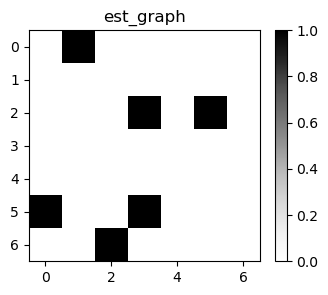

[1] Q: suppose more remains are liquified happens, how will it affect MORE oil.
   → Predicted: more | Ground Truth: more


100%|██████████| 2500/2500 [01:01<00:00, 40.82it/s]


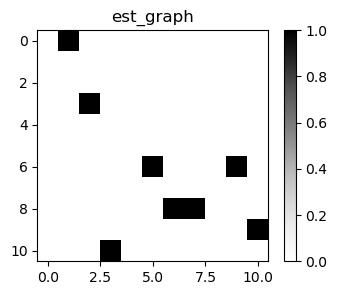

[2] Q: suppose there is not enough fuel happens, how will it affect MORE salt being removed from the water.
   → Predicted: less | Ground Truth: less


100%|██████████| 2500/2500 [00:50<00:00, 49.48it/s]


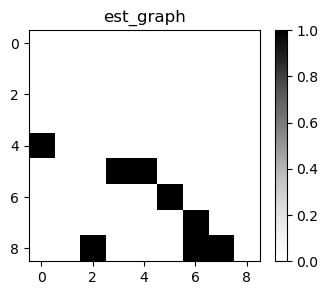

[3] Q: suppose less copper is wrapped round the wire happens, how will it affect More coal particles get mixed with the hot air.
   → Predicted: no effect | Ground Truth: no effect


100%|██████████| 2500/2500 [00:50<00:00, 49.44it/s]


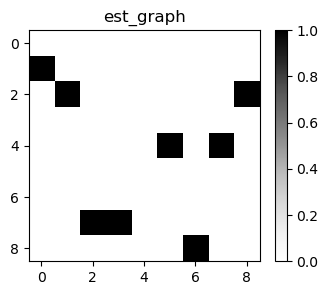

[4] Q: suppose less bile is created happens, how will it affect the liver having to work HARDER.
   → Predicted: more | Ground Truth: more


100%|██████████| 2500/2500 [01:37<00:00, 25.77it/s]


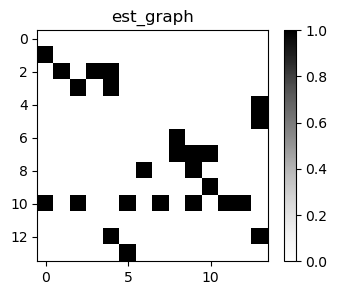

[5] Q: suppose Carbon dioxide concentration is high happens, how will it affect caves would take longer to form.
   → Predicted: more | Ground Truth: less


100%|██████████| 2500/2500 [00:46<00:00, 53.52it/s]


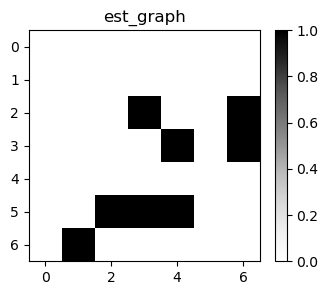

[6] Q: suppose there are no candles on the cake happens, how will it affect HELPING the water purifier to work better.
   → Predicted: no effect | Ground Truth: no effect


100%|██████████| 2500/2500 [01:21<00:00, 30.71it/s]


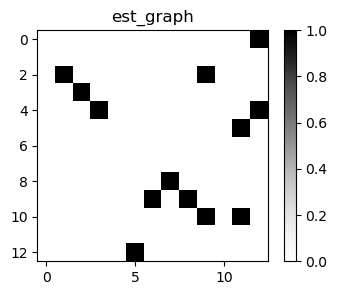

[7] Q: suppose the water is heated very quickly happens, how will it affect less dishes getting cleaned.
   → Predicted: less | Ground Truth: no effect


100%|██████████| 2500/2500 [00:50<00:00, 49.70it/s]


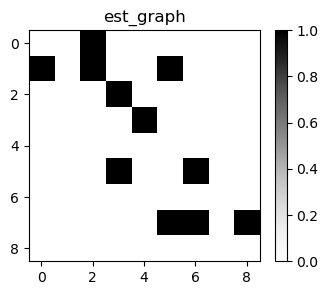

[8] Q: suppose there are more strong winds in the area happens, how will it affect the spins of the shaft spins less in the wind.
   → Predicted: more | Ground Truth: less


100%|██████████| 2500/2500 [00:48<00:00, 51.70it/s]


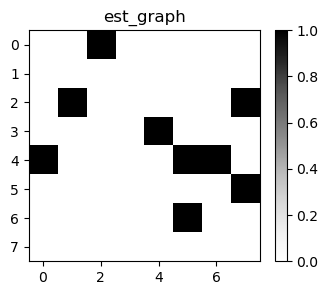

[9] Q: suppose The coffee can slips more happens, how will it affect less acid rain falls.
   → Predicted: no effect | Ground Truth: no effect


100%|██████████| 2500/2500 [01:53<00:00, 21.94it/s]


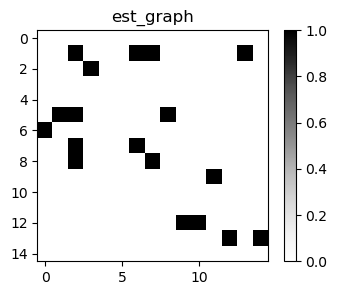

[10] Q: suppose the lung is healthy enough to remove carbon dioxide happens, how will it affect the weather becomes very poor.
   → Predicted: no effect | Ground Truth: no effect

✅ Accuracy on 10 samples: 70.00%


0.7

In [8]:
evaluate_model(model_name='llama3.1:8b',max_samples=10,rl=True)

2025-04-23 19:07:35,969 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]
2025-04-23 19:07:36,052 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:07:36,053 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:07:36,060 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.217515415732913, su: -4.697921418697092, strue: -15.217515415732912
2025-04-23 19:07:36,061 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.217515415732913, su: -4.697921418697092, lambda2: 0.01, true: -96.22897932855261
2025-04-23 19:07:36,067 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finish

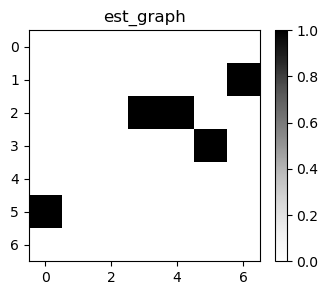

2025-04-23 19:09:38,649 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[1] Q: suppose more remains are liquified happens, how will it affect MORE oil.
   → Predicted: more | Ground Truth: more


2025-04-23 19:09:39,322 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
2025-04-23 19:09:39,469 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:09:39,470 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:09:39,478 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.293779307315546, su: -4.446579276642525, strue: -15.293779307315546
2025-04-23 19:09:39,480 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.293779307315546, su: -4.446579276642525, lambda2: 0.001, true: -59.01793931744746
2025-04-23 19:09:39,486 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finis

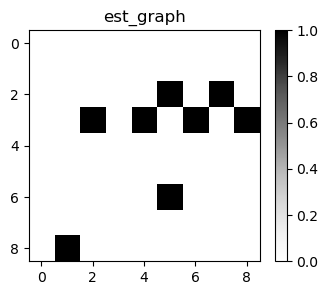

2025-04-23 19:12:12,597 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[2] Q: suppose there is not enough fuel happens, how will it affect MORE salt being removed from the water.
   → Predicted: less | Ground Truth: less


2025-04-23 19:12:14,474 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
2025-04-23 19:12:14,662 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:12:14,664 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:12:14,675 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.237647767537331, su: -4.158942834524803, strue: -15.237647767537332
2025-04-23 19:12:14,675 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.237647767537331, su: -4.158942834524803, lambda2: 0.0001, true: -46.35187850709428
2025-04-23 19:12:14,689 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Fini

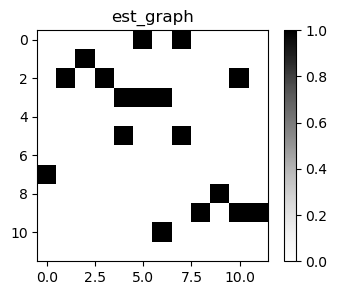

2025-04-23 19:15:31,152 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[3] Q: suppose less copper is wrapped round the wire happens, how will it affect More coal particles get mixed with the hot air.
   → Predicted: less | Ground Truth: no effect


2025-04-23 19:15:31,610 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]
2025-04-23 19:15:31,694 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:15:31,695 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:15:31,701 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.488285533489563, su: -4.56438411722169, strue: -15.488285533489563
2025-04-23 19:15:31,702 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.488285533489563, su: -4.56438411722169, lambda2: 0.001, true: -54.11832812420231
2025-04-23 19:15:31,708 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finishe

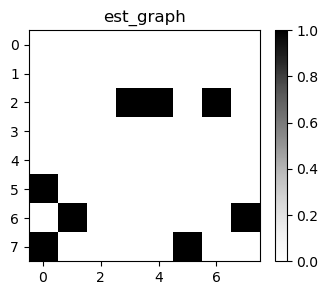

2025-04-23 19:17:41,504 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[4] Q: suppose less bile is created happens, how will it affect the liver having to work HARDER.
   → Predicted: more | Ground Truth: more


2025-04-23 19:17:41,920 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]
2025-04-23 19:17:42,068 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:17:42,069 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:17:42,081 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.600350347303751, su: -4.34127896485043, strue: -15.60035034730375
2025-04-23 19:17:42,081 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.600350347303751, su: -4.34127896485043, lambda2: 0.001, true: -39.71180720712926
2025-04-23 19:17:42,093 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finished

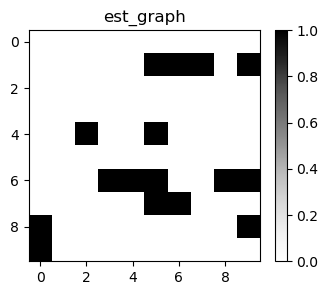

2025-04-23 19:20:17,061 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[5] Q: suppose Carbon dioxide concentration is high happens, how will it affect caves would take longer to form.
   → Predicted: less | Ground Truth: less


2025-04-23 19:20:17,655 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]
2025-04-23 19:20:17,737 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:20:17,737 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:20:17,748 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.5333210283295955, su: -4.69800775093469, strue: -15.533321028329595
2025-04-23 19:20:17,748 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.5333210283295955, su: -4.69800775093469, lambda2: 0.01, true: -59.85778192815896
2025-04-23 19:20:17,754 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finish

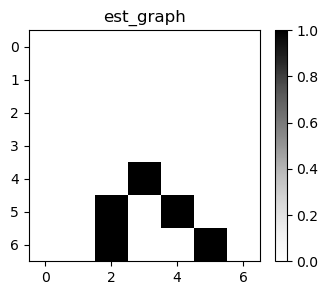

2025-04-23 19:22:26,432 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[6] Q: suppose there are no candles on the cake happens, how will it affect HELPING the water purifier to work better.
   → Predicted: no effect | Ground Truth: no effect


2025-04-23 19:22:26,947 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]
2025-04-23 19:22:27,061 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:22:27,061 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:22:27,071 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.248515238739818, su: -4.341230453334768, strue: -15.248515238739818
2025-04-23 19:22:27,076 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.248515238739818, su: -4.341230453334768, lambda2: 0.001, true: -55.109488006765034
2025-04-23 19:22:27,084 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Fini

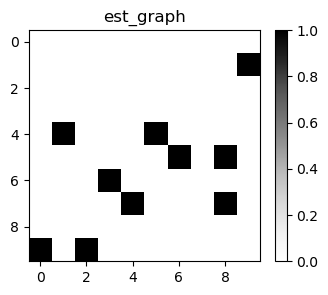

2025-04-23 19:25:06,767 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[7] Q: suppose the water is heated very quickly happens, how will it affect less dishes getting cleaned.
   → Predicted: less | Ground Truth: no effect


2025-04-23 19:25:07,480 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
2025-04-23 19:25:07,626 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:25:07,628 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:25:07,639 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.601918616179339, su: -4.446626978774101, strue: -15.60191861617934
2025-04-23 19:25:07,639 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.601918616179339, su: -4.446626978774101, lambda2: 0.001, true: -43.279115316976586
2025-04-23 19:25:07,648 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finis

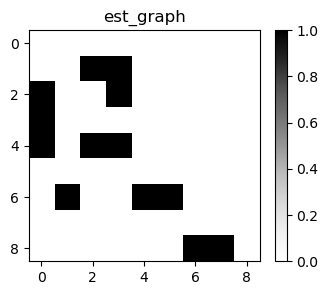

2025-04-23 19:27:41,328 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[8] Q: suppose there are more strong winds in the area happens, how will it affect the spins of the shaft spins less in the wind.
   → Predicted: less | Ground Truth: less


2025-04-23 19:27:42,893 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]
2025-04-23 19:27:43,038 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:27:43,038 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:27:43,053 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.121152271326458, su: -4.3412857031817556, strue: -15.121152271326459
2025-04-23 19:27:43,053 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.121152271326458, su: -4.3412857031817556, lambda2: 0.001, true: -64.11353177883969
2025-04-23 19:27:43,062 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Fin

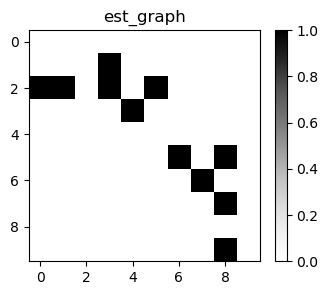

2025-04-23 19:30:18,897 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[9] Q: suppose The coffee can slips more happens, how will it affect less acid rain falls.
   → Predicted: no effect | Ground Truth: no effect


2025-04-23 19:30:21,519 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
Extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
2025-04-23 19:30:21,765 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:222] - INFO: GPU is available.
2025-04-23 19:30:21,766 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.12.7
2025-04-23 19:30:21,780 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: -5.299970293951196, su: -4.0048532924218065, strue: -15.299970293951196
2025-04-23 19:30:21,781 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: -5.299970293951196, su: -4.0048532924218065, lambda2: 1e-05, true: -38.606550559490415
2025-04-23 19:30:21,788 - d:\WorkSpace\dc\ncastle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Fi

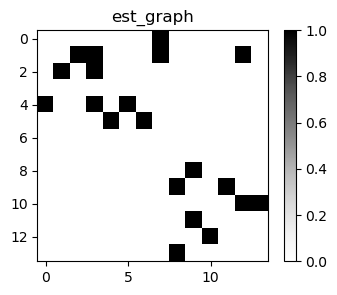

2025-04-23 19:34:38,815 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


[10] Q: suppose the lung is healthy enough to remove carbon dioxide happens, how will it affect the weather becomes very poor.
   → Predicted: less | Ground Truth: no effect

✅ Accuracy on 10 samples: 70.00%


0.7

In [3]:
evaluate_model(model_name='llama3.1:8b',max_samples=10,rl=True,encoder_type='FlashformerEncoder')

In [5]:
import logging
logging.disable(logging.CRITICAL)
evaluate_model(model_name='llama3.1:8b',max_samples=10)

[1] Q: suppose the climate becomes more favourable happens, how will it affect less gas is trapped.
   → Predicted: more | Ground Truth: more
[2] Q: suppose eggs are available happens, how will it affect the cake will not rise.
   → Predicted: less | Ground Truth: less
[3] Q: suppose a baby bird is raised by a male and female bird happens, how will it affect baby bird ends up dying.
   → Predicted: less | Ground Truth: less
[4] Q: suppose there has not been a large loss of blood happens, how will it affect the blood will carry less oxygen.
   → Predicted: no effect | Ground Truth: less
[5] Q: suppose more muscles available happens, how will it affect LESS or LESS POWERFUL lightning.
   → Predicted: no effect | Ground Truth: no effect
[6] Q: suppose insecticide kills Bees at hive happens, how will it affect hive gets bigger.
   → Predicted: less | Ground Truth: less
[7] Q: suppose less pressure on the rocks happens, how will it affect Cutting a deeper gash.
   → Predicted: less | Ground

0.6